In [2]:
!pip install torchvision


In [3]:
!pip install scikit-learn
!pip install torchvision


In [7]:
!pip install scikit-image


In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from scipy.spatial import distance
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import measure
from scipy.ndimage import binary_dilation, binary_erosion

## To extract the number of veins, midrib length and to detect edges:

### Attempt one to extract all the details: Mid rib length calculation is good.

C:\Users\Admin\AppData\Local\Temp\ipykernel_25148\1803903741.py:138: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25148\1803903741.py:174: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


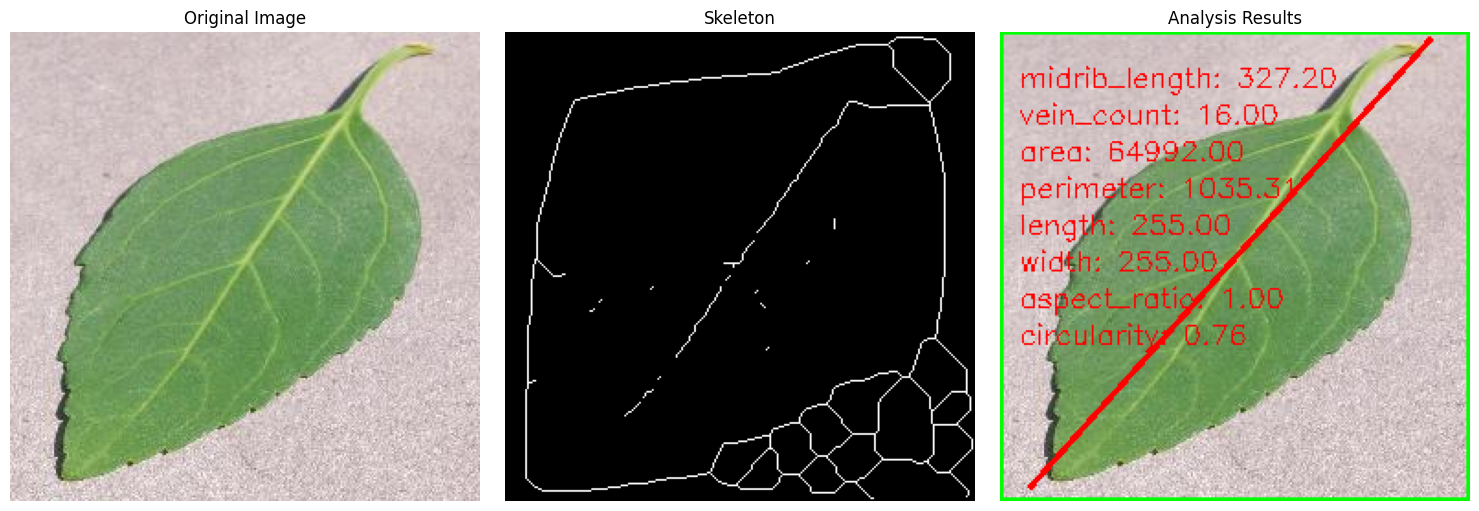


Leaf Measurements:
midrib_length: 327.20
vein_count: 16.00
area: 64992.00
perimeter: 1035.31
length: 255.00
width: 255.00
aspect_ratio: 1.00
circularity: 0.76


In [6]:

class LeafAnalyzer:
    def __init__(self, image_path):
        self.original = cv2.imread(image_path)
        if self.original is None:
            raise ValueError("Could not read the image")
        self.height, self.width = self.original.shape[:2]
        self.preprocessed = None
        self.binary = None
        self.skeleton = None
        self.features = {}

    def preprocess(self):
        """
        Preprocess the leaf image for feature extraction
        """
        # Convert to grayscale
        gray = cv2.cvtColor(self.original, cv2.COLOR_BGR2GRAY)
        
        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        
        # Denoise
        denoised = cv2.fastNlMeansDenoising(enhanced)
        
        # Gaussian blur
        blurred = cv2.GaussianBlur(denoised, (5, 5), 0)
        
        self.preprocessed = blurred
        return self

    def create_binary_mask(self):
        """
        Create binary mask of the leaf
        """
        # Otsu's thresholding
        _, binary = cv2.threshold(self.preprocessed, 0, 255, 
                                cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Clean up noise
        kernel = np.ones((3,3), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        
        self.binary = binary
        return self

    def detect_edges(self):
        """
        Apply Canny edge detection
        """
        # Calculate threshold values
        median = np.median(self.preprocessed)
        lower = int(max(0, (1.0 - 0.33) * median))
        upper = int(min(255, (1.0 + 0.33) * median))
        
        edges = cv2.Canny(self.preprocessed, lower, upper)
        return edges

    def extract_skeleton(self):
        """
        Extract skeleton of the leaf
        """
        # Convert binary image to boolean array
        binary_bool = self.binary > 0
        
        # Apply skeletonization
        skeleton = skeletonize(binary_bool)
        self.skeleton = np.uint8(skeleton * 255)
        return self

    def find_midrib(self):
        """
        Detect and measure the midrib
        """
        # Find contours of the skeleton
        contours, _ = cv2.findContours(self.skeleton, cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_NONE)
        
        if not contours:
            return None
        
        # Assume the longest contour is the midrib
        midrib = max(contours, key=cv2.contourArea)
        
        # Get midrib endpoints
        pts = midrib.reshape(-1, 2)
        dists = distance.cdist(pts, pts)
        i, j = np.unravel_index(dists.argmax(), dists.shape)
        endpoints = [pts[i], pts[j]]
        
        midrib_length = np.max(dists)
        self.features['midrib_length'] = midrib_length
        self.features['midrib_endpoints'] = endpoints
        
        return midrib

    def detect_veins(self):
        """
        Detect and analyze leaf veins
        """
        # Apply edge detection
        edges = self.detect_edges()
        
        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_LIST, 
                                     cv2.CHAIN_APPROX_NONE)
        
        # Filter contours based on length and orientation
        veins = []
        for contour in contours:
            length = cv2.arcLength(contour, False)
            if length > self.width * 0.1:  # Minimum length threshold
                veins.append(contour)
        
        self.features['vein_count'] = len(veins)
        return veins

    def analyze_shape(self):
        """
        Analyze leaf shape characteristics
        """
        # Find contours of the binary mask
        contours, _ = cv2.findContours(self.binary, cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return
            
        contour = max(contours, key=cv2.contourArea)
        
        # Calculate basic shape metrics
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        # Find minimum bounding rectangle
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        # Calculate length and width
        width = min(rect[1])
        length = max(rect[1])
        
        # Calculate shape features
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        aspect_ratio = length / width if width > 0 else 0
        
        self.features.update({
            'area': area,
            'perimeter': perimeter,
            'length': length,
            'width': width,
            'aspect_ratio': aspect_ratio,
            'circularity': circularity
        })

    def visualize_results(self):
        """
        Create visualization of detected features
        """
        # Create RGB image for visualization
        result = cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB)
        
        # Draw midrib
        if 'midrib_endpoints' in self.features:
            pts = self.features['midrib_endpoints']
            cv2.line(result, tuple(pts[0]), tuple(pts[1]), (255, 0, 0), 2)
        
        # Draw minimum bounding rectangle
        if 'length' in self.features:
            rect = cv2.minAreaRect(cv2.findContours(self.binary, cv2.RETR_EXTERNAL, 
                                                   cv2.CHAIN_APPROX_SIMPLE)[0][0])
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(result, [box], 0, (0, 255, 0), 2)
        
        # Add text with measurements
        font = cv2.FONT_HERSHEY_SIMPLEX
        y = 30
        for key, value in self.features.items():
            if isinstance(value, (int, float)):
                text = f"{key}: {value:.2f}"
                cv2.putText(result, text, (10, y), font, 0.5, (255, 0, 0), 1)
                y += 20
        
        return result

    def analyze(self):
        """
        Run complete analysis pipeline
        """
        self.preprocess()
        self.create_binary_mask()
        self.extract_skeleton()
        self.find_midrib()
        self.detect_veins()
        self.analyze_shape()
        return self.features

def main(image_path):
    """
    Main function to process leaf image and display results
    """
    # Create analyzer instance
    analyzer = LeafAnalyzer(image_path)
    
    try:
        # Run analysis
        features = analyzer.analyze()
        
        # Get visualization
        result_image = analyzer.visualize_results()
        
        # Display results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.imshow(cv2.cvtColor(analyzer.original, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(analyzer.skeleton, cmap='gray')
        plt.title('Skeleton')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(result_image)
        plt.title('Analysis Results')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed measurements
        print("\nLeaf Measurements:")
        for key, value in features.items():
            if isinstance(value, (int, float)):
                print(f"{key}: {value:.2f}")
                
    except Exception as e:
        print(f"Error during analysis: {str(e)}")

# Example usage
if __name__ == "__main__":
    image_path = r"C:\Users\Admin\\align_together\plant_detection\\124e5b7b-dc6a-4b5a-8f4e-b22ed738b5fc___JR_HL 9455_flipTB.jpg"
    main(image_path)

### Attempt 2

C:\Users\Admin\AppData\Local\Temp\ipykernel_25148\860994825.py:130: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
C:\Users\Admin\AppData\Local\Temp\ipykernel_25148\860994825.py:161: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


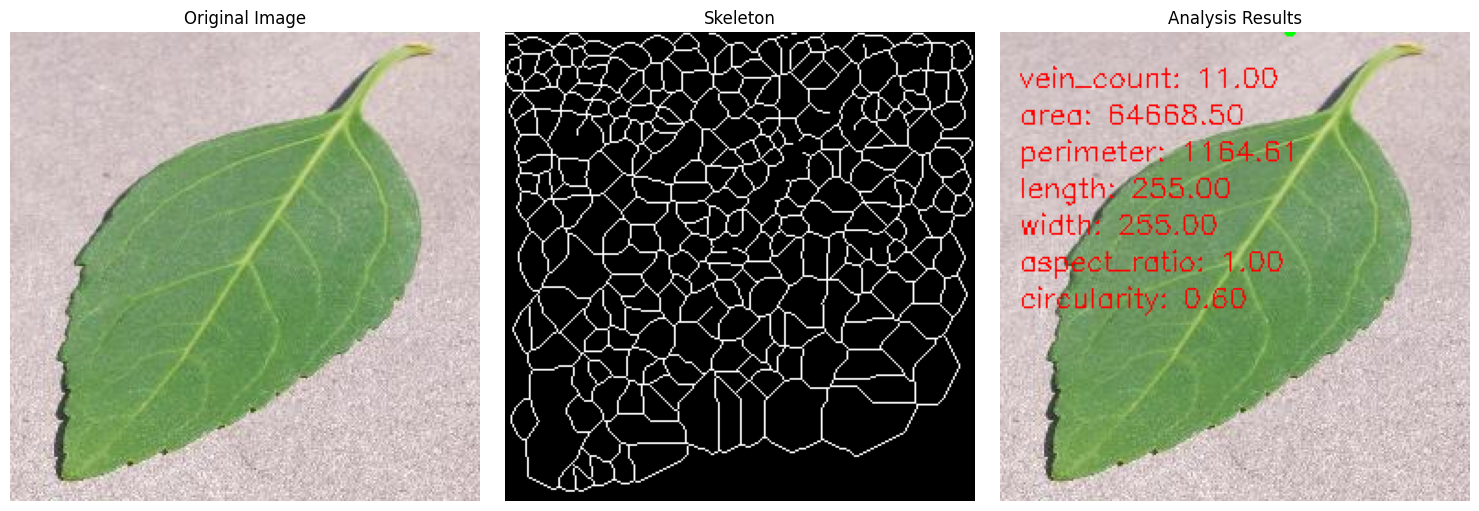


Leaf Measurements:
vein_count: 11.00
area: 64668.50
perimeter: 1164.61
length: 255.00
width: 255.00
aspect_ratio: 1.00
circularity: 0.60


In [7]:
class LeafAnalyzer:
    def __init__(self, image_path):
        self.original = cv2.imread(image_path)
 
        if self.original is None:
            raise ValueError("Could not read the image")
        self.height, self.width = self.original.shape[:2]
        self.preprocessed = None
        self.binary = None
        self.skeleton = None
        self.features = {}

    def preprocess(self):
        """
        Preprocess the leaf image for feature extraction
        """
        # Convert to grayscale
        gray = cv2.cvtColor(self.original, cv2.COLOR_BGR2GRAY)
        
        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        
        # Denoise
        denoised = cv2.fastNlMeansDenoising(enhanced)
        
        # Adaptive Gaussian Thresholding
        self.preprocessed = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                  cv2.THRESH_BINARY, 11, 2)
        return self

    def create_binary_mask(self):
        """
        Create binary mask of the leaf
        """
        # Morphological operations for cleaning up
        kernel = np.ones((3, 3), np.uint8)
        binary = cv2.morphologyEx(self.preprocessed, cv2.MORPH_CLOSE, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        
        self.binary = binary
        return self

    def detect_edges(self):
        """
        Apply Sobel and Canny edge detection to emphasize veins and edges
        """
        # Sobel Gradient Calculation for better vein edge detection
        sobelx = cv2.Sobel(self.preprocessed, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(self.preprocessed, cv2.CV_64F, 0, 1, ksize=5)
        sobel_combined = cv2.sqrt(sobelx**2 + sobely**2)
        
        # Canny edge detection
        edges = cv2.Canny(np.uint8(sobel_combined), 50, 150)
        return edges

    def extract_skeleton(self):
        """
        Extract skeleton of the leaf
        """
        # Convert binary image to boolean array
        binary_bool = self.binary > 0
        
        # Apply skeletonization using morphological thinning
        skeleton = thin(binary_bool)
        self.skeleton = np.uint8(skeleton * 255)
        return self

    def find_midrib(self):
        """
        Detect and measure the midrib using Hough Line Transform
        """
        # Use HoughLinesP to detect straight lines (suitable for midrib)
        lines = cv2.HoughLinesP(self.skeleton, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
        
        longest_line = None  # Initialize longest_line to None
        
        if lines is not None:
            # Assume the longest detected line is the midrib
            longest_line = max(lines, key=lambda line: np.linalg.norm([line[0][2] - line[0][0], line[0][3] - line[0][1]]))
            x1, y1, x2, y2 = longest_line[0]
            
            # Calculate midrib length
            midrib_length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            self.features['midrib_length'] = midrib_length
            self.features['midrib_endpoints'] = [(x1, y1), (x2, y2)]
        
        return longest_line

    def detect_veins(self):
        """
        Detect and analyze leaf veins using Watershed segmentation
        """
        # Detect edges
        edges = self.detect_edges()
        
        # Apply Watershed algorithm to segment veins
        dist_transform = cv2.distanceTransform(cv2.bitwise_not(self.binary), cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(cv2.bitwise_not(self.binary), sure_fg)
        
        # Markers for watershed
        ret, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0
        
        markers = cv2.watershed(self.original, markers)
        
        # Count the number of detected veins
        vein_count = len(np.unique(markers)) - 2  # excluding background and midrib
        self.features['vein_count'] = vein_count
        return markers

    def analyze_shape(self):
        """
        Analyze leaf shape characteristics
        """
        contours, _ = cv2.findContours(self.binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return
        
        contour = max(contours, key=cv2.contourArea)
        
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        width = min(rect[1])
        length = max(rect[1])
        
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        aspect_ratio = length / width if width > 0 else 0
        
        self.features.update({
            'area': area,
            'perimeter': perimeter,
            'length': length,
            'width': width,
            'aspect_ratio': aspect_ratio,
            'circularity': circularity
        })

    def visualize_results(self):
        """
        Create visualization of detected features
        """
        result = cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB)
        
        if 'midrib_endpoints' in self.features:
            pts = self.features['midrib_endpoints']
            cv2.line(result, tuple(pts[0]), tuple(pts[1]), (255, 0, 0), 2)
        
        if 'length' in self.features:
            rect = cv2.minAreaRect(cv2.findContours(self.binary, cv2.RETR_EXTERNAL, 
                                                   cv2.CHAIN_APPROX_SIMPLE)[0][0])
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(result, [box], 0, (0, 255, 0), 2)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        y = 30
        for key, value in self.features.items():
            if isinstance(value, (int, float)):
                text = f"{key}: {value:.2f}"
                cv2.putText(result, text, (10, y), font, 0.5, (255, 0, 0), 1)
                y += 20
        
        return result

    def analyze(self):
        """
        Run complete analysis pipeline
        """
        self.preprocess()
        self.create_binary_mask()
        self.extract_skeleton()
        self.find_midrib()
        self.detect_veins()
        self.analyze_shape()
        return self.features

def main(image_path):
    """
    Main function to process leaf image and display results
    """
    analyzer = LeafAnalyzer(image_path)
    
    try:
        features = analyzer.analyze()
        
        result_image = analyzer.visualize_results()
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.imshow(cv2.cvtColor(analyzer.original, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(analyzer.skeleton, cmap='gray')
        plt.title('Skeleton')
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(result_image)
        plt.title('Analysis Results')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("\nLeaf Measurements:")
        for key, value in features.items():
            if isinstance(value, (int, float)):
                print(f"{key}: {value:.2f}")
                
    except Exception as e:
        print(f"Error during analysis: {str(e)}")

# Example usage
if __name__ == "__main__":
    image_path = r"C:\\Users\Admin\\align_together\\plant_detection\\124e5b7b-dc6a-4b5a-8f4e-b22ed738b5fc___JR_HL 9455_flipTB.jpg"
    main(image_path)


In [16]:
import cv2
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, thin, medial_axis
from skimage import measure
from scipy.ndimage import gaussian_filter

class LeafAnalyzer:
    def __init__(self, image_path):
        self.original = cv2.imread(image_path)
        if self.original is None:
            raise ValueError("Could not read the image")
        self.height, self.width = self.original.shape[:2]
        self.preprocessed = None
        self.binary = None
        self.skeleton = None
        self.features = {}
        self.veins = None

    def preprocess(self):
        """
        Enhanced preprocessing pipeline optimized for vein detection
        """
        # Convert to LAB color space
        lab = cv2.cvtColor(self.original, cv2.COLOR_BGR2LAB)
        l_channel = lab[:,:,0]
        
        # Apply CLAHE with optimized parameters
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        enhanced = clahe.apply(l_channel)
        
        # Create multiple Gaussian blurred images
        blur1 = cv2.GaussianBlur(enhanced, (3,3), 0)
        blur2 = cv2.GaussianBlur(enhanced, (9,9), 0)
        
        # Create DoG (Difference of Gaussians)
        dog = cv2.subtract(blur1, blur2)
        
        # Enhance contrast
        dog = cv2.convertScaleAbs(dog, alpha=1.5, beta=0)
        
        # Apply bilateral filter to preserve edges while reducing noise
        denoised = cv2.bilateralFilter(dog, 9, 75, 75)
        
        self.preprocessed = denoised
        return self

    def create_binary_mask(self):
        """
        Create refined binary mask with improved leaf segmentation
        """
        # Multi-level thresholding
        _, binary1 = cv2.threshold(self.preprocessed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        adaptive = cv2.adaptiveThreshold(
            self.preprocessed,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            11,
            2
        )
        
        # Combine both thresholds
        binary = cv2.bitwise_or(binary1, adaptive)
        
        # Clean up noise while preserving fine details
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
        # Fill holes
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            main_contour = max(contours, key=cv2.contourArea)
            mask = np.zeros_like(binary)
            cv2.drawContours(mask, [main_contour], -1, 255, -1)
            binary = cv2.bitwise_and(binary, mask)
        
        self.binary = binary
        return self

    def detect_veins(self):
        """
        Enhanced vein detection using multiple OpenCV techniques
        """
        # Create empty mask for veins
        vein_mask = np.zeros_like(self.preprocessed)
        
        # 1. Edge detection using multiple methods
        # Sobel edges
        sobelx = cv2.Sobel(self.preprocessed, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(self.preprocessed, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.sqrt(sobelx**2 + sobely**2)
        sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        # Laplacian edges
        laplacian = cv2.Laplacian(self.preprocessed, cv2.CV_64F)
        laplacian = np.uint8(np.absolute(laplacian))
        
        # 2. Local adaptive thresholding
        adaptive_thresh = cv2.adaptiveThreshold(
            self.preprocessed,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            7,  # smaller window for finer details
            2
        )
        
        # 3. Gradient magnitude thresholding
        gradX = cv2.Sobel(self.preprocessed, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
        gradY = cv2.Sobel(self.preprocessed, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
        gradient = cv2.magnitude(gradX, gradY)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        # Combine different detection methods
        vein_mask = cv2.bitwise_or(sobel, laplacian)
        # vein_mask = cv2.bitwise_or(vein_mask, gradient)
        vein_mask = cv2.bitwise_and(vein_mask, self.binary)
        
        # Apply threshold to get binary vein mask
        _, vein_mask = cv2.threshold(vein_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Thin the veins
        vein_skeleton = skeletonize(vein_mask > 0)
        self.veins = np.uint8(vein_skeleton * 255)
        
        # Clean up small segments
        contours, _ = cv2.findContours(self.veins, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for contour in contours:
            if cv2.arcLength(contour, False) < 10:  # Remove very small segments
                cv2.drawContours(self.veins, [contour], -1, 0, -1)
        
        # Extract vein features
        labeled_veins = measure.label(self.veins > 0)
        vein_props = measure.regionprops(labeled_veins)
        
        # Calculate vein metrics
        self.features.update({
            'vein_count': len(vein_props),
            'total_vein_length': sum(prop.perimeter for prop in vein_props),
            'avg_vein_length': np.mean([prop.perimeter for prop in vein_props]) if vein_props else 0,
            'vein_density': np.sum(self.veins > 0) / np.sum(self.binary > 0) if np.sum(self.binary > 0) else 0
        })
        
        return self

    def find_midrib(self):
        """
        Enhanced midrib detection using distance transform and skeletonization
        """
        # Get distance transform and skeleton
        dist_transform = cv2.distanceTransform(self.binary, cv2.DIST_L2, 5)
        _, skeleton = cv2.threshold(self.veins, 0, 255, cv2.THRESH_BINARY)
        
        # Weight skeleton by distance transform
        weighted_skel = skeleton.copy()
        weighted_skel[skeleton > 0] = dist_transform[skeleton > 0]
        
        # Find the longest path
        contours, _ = cv2.findContours(skeleton, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        
        if contours:
            # Get the contour with highest average distance transform value
            max_avg_dist = 0
            midrib_contour = None
            
            for contour in contours:
                mask = np.zeros_like(skeleton)
                cv2.drawContours(mask, [contour], -1, 255, 1)
                avg_dist = np.mean(dist_transform[mask > 0])
                
                if avg_dist > max_avg_dist and cv2.arcLength(contour, False) > self.width * 0.5:
                    max_avg_dist = avg_dist
                    midrib_contour = contour
            
            if midrib_contour is not None:
                # Find endpoints
                distances = distance.cdist(midrib_contour.reshape(-1, 2), 
                                        midrib_contour.reshape(-1, 2))
                i, j = np.unravel_index(distances.argmax(), distances.shape)
                endpoints = [midrib_contour[i][0], midrib_contour[j][0]]
                
                self.features.update({
                    'midrib_length': distances[i][j],
                    'midrib_endpoints': endpoints,
                    'midrib_width': max_avg_dist * 2  # Diameter from radius
                })
        
        return self

    def analyze_shape(self):
        """
        Enhanced shape analysis with additional metrics
        """
        contours, _ = cv2.findContours(self.binary, cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return
            
        contour = max(contours, key=cv2.contourArea)
        
        # Basic metrics
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        # Fit ellipse
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            major_axis = max(ellipse[1])
            minor_axis = min(ellipse[1])
        else:
            major_axis = minor_axis = 0
        
        # Calculate advanced shape features
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area > 0 else 0
        
        # Calculate moments and orientation
        moments = cv2.moments(contour)
        if moments['m00'] != 0:
            cx = int(moments['m10'] / moments['m00'])
            cy = int(moments['m01'] / moments['m00'])
            orientation = 0.5 * np.arctan2(2 * moments['mu11'], 
                                         moments['mu20'] - moments['mu02'])
        else:
            cx = cy = orientation = 0
        
        self.features.update({
            'area': area,
            'perimeter': perimeter,
            'major_axis_length': major_axis,
            'minor_axis_length': minor_axis,
            'aspect_ratio': major_axis / minor_axis if minor_axis > 0 else 0,
            'circularity': 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0,
            'solidity': solidity,
            'compactness': np.sqrt(4 * area / np.pi) / major_axis if major_axis > 0 else 0,
            'orientation_degrees': np.degrees(orientation)
        })
        
        return self

    def visualize_results(self):
        """
        Enhanced visualization with multiple views
        """
        # Create figure with subplots
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Leaf Analysis Results', fontsize=16)
        
        # Original image
        axes[0,0].imshow(cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB))
        axes[0,0].set_title('Original Image')
        axes[0,0].axis('off')
        
        # Preprocessed image
        axes[0,1].imshow(self.preprocessed, cmap='gray')
        axes[0,1].set_title('Preprocessed Image')
        axes[0,1].axis('off')
        
        # Binary mask
        axes[0,2].imshow(self.binary, cmap='gray')
        axes[0,2].set_title('Binary Mask')
        axes[0,2].axis('off')
        
        # Vein detection
        axes[1,0].imshow(self.veins, cmap='gray')
        axes[1,0].set_title('Detected Veins')
        axes[1,0].axis('off')
        
        # Results overlay
        result = cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB).copy()
        
        # Draw midrib
        if 'midrib_endpoints' in self.features:
            pts = self.features['midrib_endpoints']
            cv2.line(result, tuple(pts[0]), tuple(pts[1]), (255, 0, 0), 2)
        
        # Draw vein overlay
        result[self.veins > 0] = [0, 255, 0]
        
        axes[1,1].imshow(result)
        axes[1,1].set_title('Analysis Overlay')
        axes[1,1].axis('off')
        
        # Text results
        axes[1,2].axis('off')
        text = "Measurements:\n\n"
        for key, value in self.features.items():
            if isinstance(value, (int, float)):
                text += f"{key}: {value:.2f}\n"
        axes[1,2].text(0, 0.5, text, fontsize=8, va='center')
        
        plt.tight_layout()
        return fig

    def analyze(self):
        """
        Run complete analysis pipeline
        """
        self.preprocess()
        self.create_binary_mask()
        self.detect_veins()
        self.find_midrib()
        self.analyze_shape()
        return self.features

def main(image_path):
    """
    Main function to process leaf image and display results
    """
    analyzer = LeafAnalyzer(image_path)
    
    try:
        features = analyzer.analyze()
        fig = analyzer.visualize_results()
        plt.show()
        
        print("\nDetailed Leaf Analysis Results:")
        for key, value in features.items():
            if isinstance(value, (int, float)):
                print(f"{key}: {value:.2f}")
                
    except Exception as e:
        print(f"Error during analysis: {str(e)}")

if __name__ == "__main__":
    image_path = r"C:\\Users\Admin\\align_together\\plant_detection\\124e5b7b-dc6a-4b5a-8f4e-b22ed738b5fc___JR_HL 9455_flipTB.jpg"
    # image_path = r"C:\\Users\Admin\\align_together\\plant_detection\basil_healthy.JPG"
    image_path = r"basil_healthy.JPG"
    main(image_path)


KeyboardInterrupt: 

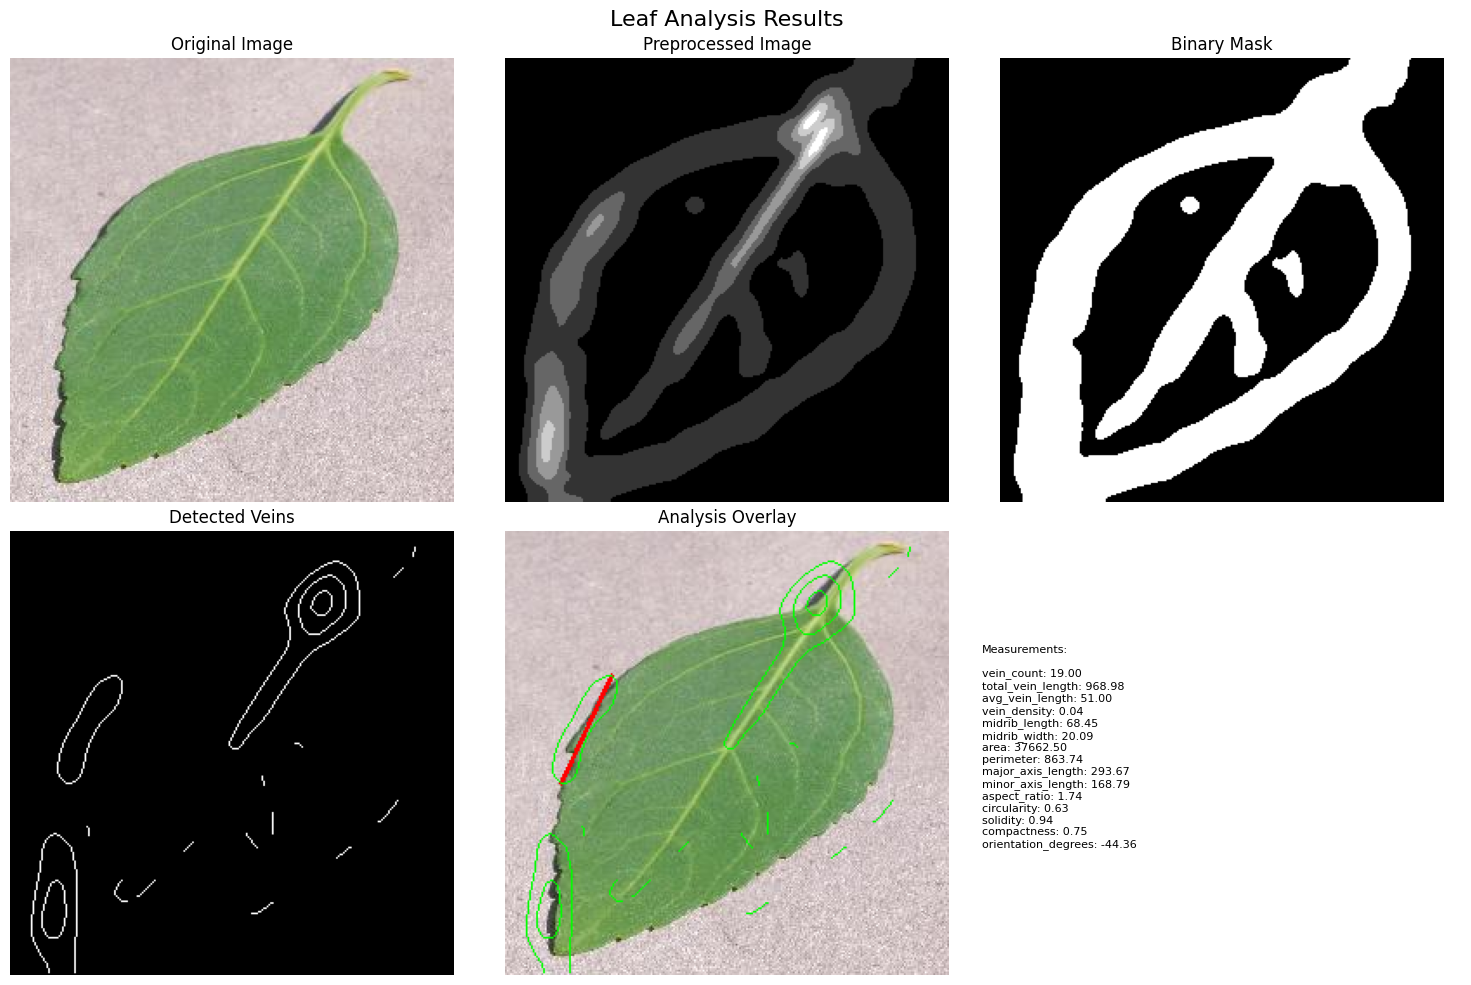


Detailed Leaf Analysis Results:
vein_count: 19.00
total_vein_length: 968.98
avg_vein_length: 51.00
vein_density: 0.04
midrib_length: 68.45
midrib_width: 20.09
area: 37662.50
perimeter: 863.74
major_axis_length: 293.67
minor_axis_length: 168.79
aspect_ratio: 1.74
circularity: 0.63
solidity: 0.94
compactness: 0.75
orientation_degrees: -44.36


In [12]:
class LeafAnalyzer:
    def __init__(self, image_path):
        self.original = cv2.imread(image_path)
        if self.original is None:
            raise ValueError("Could not read the image")
        self.height, self.width = self.original.shape[:2]
        self.preprocessed = None
        self.binary = None
        self.skeleton = None
        self.features = {}
        self.veins = None

    def remove_noise(self, image):
        """
        Advanced noise removal function using multiple techniques
        """
        # Apply median blur to remove salt-and-pepper noise
        median_filtered = cv2.medianBlur(image, 3)
        
        # Non-local means denoising for preserving edges while removing noise
        nlm_filtered = cv2.fastNlMeansDenoising(
            median_filtered,
            None,
            h=10,  # Filter strength (higher = more smoothing)
            templateWindowSize=7,  # Size of compared patches
            searchWindowSize=21  # Size of search window
        )
        
        # Bilateral filter to preserve edges while smoothing
        bilateral_filtered = cv2.bilateralFilter(
            nlm_filtered,
            d=9,  # Diameter of pixel neighborhood
            sigmaColor=75,  # Filter sigma in color space
            sigmaSpace=75  # Filter sigma in coordinate space
        )
        
        return bilateral_filtered

    def preprocess(self):
        """
        Enhanced preprocessing pipeline with improved noise reduction
        """
        # Convert to LAB color space
        lab = cv2.cvtColor(self.original, cv2.COLOR_BGR2LAB)
        l_channel = lab[:,:,0]
        
        # Initial noise reduction on L channel
        denoised_l = self.remove_noise(l_channel)
        
        # Apply CLAHE with optimized parameters
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        enhanced = clahe.apply(denoised_l)
        
        # Create multiple Gaussian blurred images with noise reduction
        blur1 = cv2.GaussianBlur(enhanced, (3,3), 0)
        blur2 = cv2.GaussianBlur(enhanced, (9,9), 0)
        
        # Create DoG (Difference of Gaussians)
        dog = cv2.subtract(blur1, blur2)
        
        # Enhance contrast
        dog = cv2.convertScaleAbs(dog, alpha=1.5, beta=0)
        
        # Final noise reduction
        self.preprocessed = self.remove_noise(dog)
        return self

    def create_binary_mask(self):
        """
        Create refined binary mask with improved noise handling
        """
        # Multi-level thresholding with noise reduction
        _, binary1 = cv2.threshold(self.preprocessed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Adaptive thresholding with reduced noise sensitivity
        adaptive = cv2.adaptiveThreshold(
            self.preprocessed,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            15,  # Increased block size for better noise handling
            4    # Increased C value to reduce noise sensitivity
        )
        
        # Combine both thresholds
        binary = cv2.bitwise_or(binary1, adaptive)
        
        # Advanced morphological operations for noise removal
        # Create a cross-shaped kernel
        cross_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
        
        # Remove small noise using opening operation
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, cross_kernel, iterations=1)
        
        # Close small gaps
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, cross_kernel, iterations=1)
        
        # Fill holes
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            # Filter out small noise contours
            significant_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]
            if significant_contours:
                main_contour = max(significant_contours, key=cv2.contourArea)
                mask = np.zeros_like(binary)
                cv2.drawContours(mask, [main_contour], -1, 255, -1)
                binary = cv2.bitwise_and(binary, mask)
        
        self.binary = binary
        return self

    def detect_veins(self):
        """
        Enhanced vein detection with improved noise handling
        """
        # Create empty mask for veins
        vein_mask = np.zeros_like(self.preprocessed)
        
        # Apply additional noise reduction before edge detection
        denoised = self.remove_noise(self.preprocessed)
        
        # Edge detection with reduced noise sensitivity
        sobelx = cv2.Sobel(denoised, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(denoised, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.sqrt(sobelx**2 + sobely**2)
        sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        # Laplacian with reduced noise sensitivity
        laplacian = cv2.Laplacian(denoised, cv2.CV_64F)
        laplacian = np.uint8(np.absolute(laplacian))
        
        # Combine edge detection results
        vein_mask = cv2.bitwise_or(sobel, laplacian)
        vein_mask = cv2.bitwise_and(vein_mask, self.binary)
        
        # Additional noise reduction on vein mask
        vein_mask = self.remove_noise(vein_mask)
        
        # Apply threshold with noise consideration
        _, vein_mask = cv2.threshold(vein_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Enhanced cleaning of small segments
        contours, _ = cv2.findContours(vein_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for contour in contours:
            if cv2.arcLength(contour, False) < 15:  # Increased minimum length threshold
                cv2.drawContours(vein_mask, [contour], -1, 0, -1)
        
        # Create skeleton with noise reduction
        vein_skeleton = skeletonize(vein_mask > 0)
        self.veins = np.uint8(vein_skeleton * 255)
        
        # Calculate vein features
        labeled_veins = measure.label(self.veins > 0)
        vein_props = measure.regionprops(labeled_veins)
        
        self.features.update({
            'vein_count': len(vein_props),
            'total_vein_length': sum(prop.perimeter for prop in vein_props),
            'avg_vein_length': np.mean([prop.perimeter for prop in vein_props]) if vein_props else 0,
            'vein_density': np.sum(self.veins > 0) / np.sum(self.binary > 0) if np.sum(self.binary > 0) else 0
        })
        
        return self
    def find_midrib(self):
        """
        Enhanced midrib detection using distance transform and skeletonization
        """
        # Get distance transform and skeleton
        dist_transform = cv2.distanceTransform(self.binary, cv2.DIST_L2, 5)
        _, skeleton = cv2.threshold(self.veins, 0, 255, cv2.THRESH_BINARY)
        
        # Weight skeleton by distance transform
        weighted_skel = skeleton.copy()
        weighted_skel[skeleton > 0] = dist_transform[skeleton > 0]
        
        # Find the longest path
        contours, _ = cv2.findContours(skeleton, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        
        if contours:
            # Get the contour with highest average distance transform value
            max_avg_dist = 0
            midrib_contour = None
            
            for contour in contours:
                mask = np.zeros_like(skeleton)
                cv2.drawContours(mask, [contour], -1, 255, 1)
                avg_dist = np.mean(dist_transform[mask > 0])
                
                if avg_dist > max_avg_dist and cv2.arcLength(contour, False) > self.width * 0.5:
                    max_avg_dist = avg_dist
                    midrib_contour = contour
            
            if midrib_contour is not None:
                # Find endpoints
                distances = distance.cdist(midrib_contour.reshape(-1, 2), 
                                        midrib_contour.reshape(-1, 2))
                i, j = np.unravel_index(distances.argmax(), distances.shape)
                endpoints = [midrib_contour[i][0], midrib_contour[j][0]]
                
                self.features.update({
                    'midrib_length': distances[i][j],
                    'midrib_endpoints': endpoints,
                    'midrib_width': max_avg_dist * 2  # Diameter from radius
                })
        
        return self

    def analyze_shape(self):
        """
        Enhanced shape analysis with additional metrics
        """
        contours, _ = cv2.findContours(self.binary, cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return
            
        contour = max(contours, key=cv2.contourArea)
        
        # Basic metrics
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        # Fit ellipse
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            major_axis = max(ellipse[1])
            minor_axis = min(ellipse[1])
        else:
            major_axis = minor_axis = 0
        
        # Calculate advanced shape features
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area > 0 else 0
        
        # Calculate moments and orientation
        moments = cv2.moments(contour)
        if moments['m00'] != 0:
            cx = int(moments['m10'] / moments['m00'])
            cy = int(moments['m01'] / moments['m00'])
            orientation = 0.5 * np.arctan2(2 * moments['mu11'], 
                                         moments['mu20'] - moments['mu02'])
        else:
            cx = cy = orientation = 0
        
        self.features.update({
            'area': area,
            'perimeter': perimeter,
            'major_axis_length': major_axis,
            'minor_axis_length': minor_axis,
            'aspect_ratio': major_axis / minor_axis if minor_axis > 0 else 0,
            'circularity': 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0,
            'solidity': solidity,
            'compactness': np.sqrt(4 * area / np.pi) / major_axis if major_axis > 0 else 0,
            'orientation_degrees': np.degrees(orientation)
        })
        
        return self

    def visualize_results(self):
        """
        Enhanced visualization with multiple views
        """
        # Create figure with subplots
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Leaf Analysis Results', fontsize=16)
        
        # Original image
        axes[0,0].imshow(cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB))
        axes[0,0].set_title('Original Image')
        axes[0,0].axis('off')
        
        # Preprocessed image
        axes[0,1].imshow(self.preprocessed, cmap='gray')
        axes[0,1].set_title('Preprocessed Image')
        axes[0,1].axis('off')
        
        # Binary mask
        axes[0,2].imshow(self.binary, cmap='gray')
        axes[0,2].set_title('Binary Mask')
        axes[0,2].axis('off')
        
        # Vein detection
        axes[1,0].imshow(self.veins, cmap='gray')
        axes[1,0].set_title('Detected Veins')
        axes[1,0].axis('off')
        
        # Results overlay
        result = cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB).copy()
        
        # Draw midrib
        if 'midrib_endpoints' in self.features:
            pts = self.features['midrib_endpoints']
            cv2.line(result, tuple(pts[0]), tuple(pts[1]), (255, 0, 0), 2)
        
        # Draw vein overlay
        result[self.veins > 0] = [0, 255, 0]
        
        axes[1,1].imshow(result)
        axes[1,1].set_title('Analysis Overlay')
        axes[1,1].axis('off')
        
        # Text results
        axes[1,2].axis('off')
        text = "Measurements:\n\n"
        for key, value in self.features.items():
            if isinstance(value, (int, float)):
                text += f"{key}: {value:.2f}\n"
        axes[1,2].text(0, 0.5, text, fontsize=8, va='center')
        
        plt.tight_layout()
        return fig

    def analyze(self):
        """
        Run complete analysis pipeline
        """
        self.preprocess()
        self.create_binary_mask()
        self.detect_veins()
        self.find_midrib()
        self.analyze_shape()
        return self.features

def main(image_path):
    """
    Main function to process leaf image and display results
    """
    analyzer = LeafAnalyzer(image_path)
    
    try:
        features = analyzer.analyze()
        fig = analyzer.visualize_results()
        plt.show()
        
        print("\nDetailed Leaf Analysis Results:")
        for key, value in features.items():
            if isinstance(value, (int, float)):
                print(f"{key}: {value:.2f}")
                
    except Exception as e:
        print(f"Error during analysis: {str(e)}")

if __name__ == "__main__":
    image_path = r"C:\\Users\Admin\\align_together\\plant_detection\\124e5b7b-dc6a-4b5a-8f4e-b22ed738b5fc___JR_HL 9455_flipTB.jpg"
    main(image_path)

In [ ]:
import cv2
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, thin, medial_axis
from skimage import measure
from scipy.ndimage import gaussian_filter

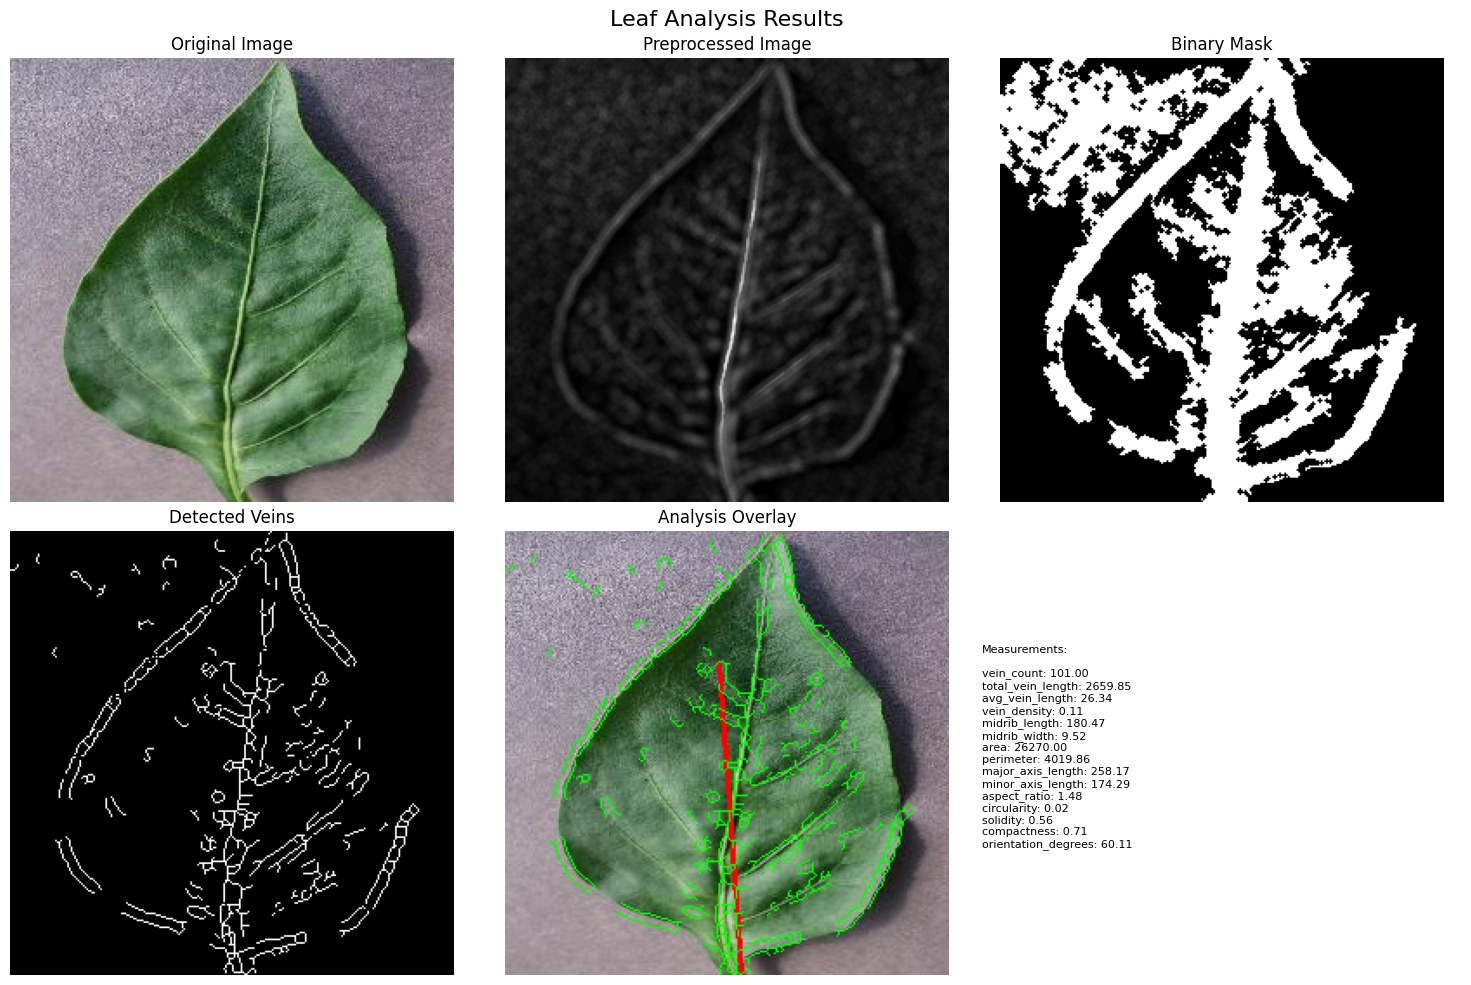


Detailed Leaf Analysis Results:
vein_count: 101.00
total_vein_length: 2659.85
avg_vein_length: 26.34
vein_density: 0.11
midrib_length: 180.47
midrib_width: 9.52
area: 26270.00
perimeter: 4019.86
major_axis_length: 258.17
minor_axis_length: 174.29
aspect_ratio: 1.48
circularity: 0.02
solidity: 0.56
compactness: 0.71
orientation_degrees: 60.11


In [153]:
class LeafAnalyzer:
    def __init__(self, image_path):
        self.original = cv2.imread(image_path)
        if self.original is None:
            raise ValueError("Could not read the image")
        self.height, self.width = self.original.shape[:2]
        self.preprocessed = None
        self.binary = None
        self.skeleton = None
        self.features = {}
        self.veins = None

    def preprocess(self):
        """
        Enhanced preprocessing pipeline optimized for vein detection
        """
        # Convert to LAB color space
        lab = cv2.cvtColor(self.original, cv2.COLOR_BGR2LAB)
        l_channel = lab[:,:,0]
        
        # Apply CLAHE with optimized parameters
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        enhanced = clahe.apply(l_channel)
        
        # Create multiple Gaussian blurred images
        blur1 = cv2.GaussianBlur(enhanced, (3,3), 0)
        blur2 = cv2.GaussianBlur(enhanced, (9,9), 0)
        
        # Create DoG (Difference of Gaussians)
        dog = cv2.subtract(blur1, blur2)
        
        # Enhance contrast
        dog = cv2.convertScaleAbs(dog, alpha=1.5, beta=0)
        
        # Apply bilateral filter to preserve edges while reducing noise
        denoised = cv2.bilateralFilter(dog, 9, 75, 75)
        
        self.preprocessed = denoised
        return self

    def create_binary_mask(self):
        """
        Create refined binary mask with improved leaf segmentation
        """
        # Multi-level thresholding
        _, binary1 = cv2.threshold(self.preprocessed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        adaptive = cv2.adaptiveThreshold(
            self.preprocessed,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            11,
            2
        )
        
        # Combine both thresholds
        binary = cv2.bitwise_or(binary1, adaptive)
        
        # Clean up noise while preserving fine details
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
        # Fill holes
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            main_contour = max(contours, key=cv2.contourArea)
            mask = np.zeros_like(binary)
            cv2.drawContours(mask, [main_contour], -1, 255, -1)
            binary = cv2.bitwise_and(binary, mask)
        
        self.binary = binary
        return self

    def detect_veins(self):
        """
        Enhanced vein detection using multiple OpenCV techniques
        """
        # Create empty mask for veins
        vein_mask = np.zeros_like(self.preprocessed)
        
        # 1. Edge detection using multiple methods
        # Sobel edges
        sobelx = cv2.Sobel(self.preprocessed, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(self.preprocessed, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.sqrt(sobelx**2 + sobely**2)
        sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        # Laplacian edges
        laplacian = cv2.Laplacian(self.preprocessed, cv2.CV_64F)
        laplacian = np.uint8(np.absolute(laplacian))
        
        # 2. Local adaptive thresholding
        adaptive_thresh = cv2.adaptiveThreshold(
            self.preprocessed,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            7,  # smaller window for finer details
            2
        )
        
        # 3. Gradient magnitude thresholding
        gradX = cv2.Sobel(self.preprocessed, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
        gradY = cv2.Sobel(self.preprocessed, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
        gradient = cv2.magnitude(gradX, gradY)
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        # Combine different detection methods
        vein_mask = cv2.bitwise_or(sobel, laplacian)
        # vein_mask = cv2.bitwise_or(vein_mask, gradient)
        vein_mask = cv2.bitwise_and(vein_mask, self.binary)
        
        # Apply threshold to get binary vein mask
        _, vein_mask = cv2.threshold(vein_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Thin the veins
        vein_skeleton = skeletonize(vein_mask > 0)
        self.veins = np.uint8(vein_skeleton * 255)
        
        # Clean up small segments
        contours, _ = cv2.findContours(self.veins, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for contour in contours:
            if cv2.arcLength(contour, False) < 10:  # Remove very small segments
                cv2.drawContours(self.veins, [contour], -1, 0, -1)
        
        # Extract vein features
        labeled_veins = measure.label(self.veins > 0)
        vein_props = measure.regionprops(labeled_veins)
        
        # Calculate vein metrics
        self.features.update({
            'vein_count': len(vein_props),
            'total_vein_length': sum(prop.perimeter for prop in vein_props),
            'avg_vein_length': np.mean([prop.perimeter for prop in vein_props]) if vein_props else 0,
            'vein_density': np.sum(self.veins > 0) / np.sum(self.binary > 0) if np.sum(self.binary > 0) else 0
        })
        
        return self

    def find_midrib(self):
        """
        Enhanced midrib detection using distance transform and skeletonization
        """
        # Get distance transform and skeleton
        dist_transform = cv2.distanceTransform(self.binary, cv2.DIST_L2, 5)
        _, skeleton = cv2.threshold(self.veins, 0, 255, cv2.THRESH_BINARY)
        
        # Weight skeleton by distance transform
        weighted_skel = skeleton.copy()
        weighted_skel[skeleton > 0] = dist_transform[skeleton > 0]
        
        # Find the longest path
        contours, _ = cv2.findContours(skeleton, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        
        if contours:
            # Get the contour with highest average distance transform value
            max_avg_dist = 0
            midrib_contour = None
            
            for contour in contours:
                mask = np.zeros_like(skeleton)
                cv2.drawContours(mask, [contour], -1, 255, 1)
                avg_dist = np.mean(dist_transform[mask > 0])
                
                if avg_dist > max_avg_dist and cv2.arcLength(contour, False) > self.width * 0.5:
                    max_avg_dist = avg_dist
                    midrib_contour = contour
            
            if midrib_contour is not None:
                # Find endpoints
                distances = distance.cdist(midrib_contour.reshape(-1, 2), 
                                        midrib_contour.reshape(-1, 2))
                i, j = np.unravel_index(distances.argmax(), distances.shape)
                endpoints = [midrib_contour[i][0], midrib_contour[j][0]]
                
                self.features.update({
                    'midrib_length': distances[i][j],
                    'midrib_endpoints': endpoints,
                    'midrib_width': max_avg_dist * 2  # Diameter from radius
                })
        
        return self

    def analyze_shape(self):
        """
        Enhanced shape analysis with additional metrics
        """
        contours, _ = cv2.findContours(self.binary, cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return
            
        contour = max(contours, key=cv2.contourArea)
        
        # Basic metrics
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        # Fit ellipse
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            major_axis = max(ellipse[1])
            minor_axis = min(ellipse[1])
        else:
            major_axis = minor_axis = 0
        
        # Calculate advanced shape features
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area > 0 else 0
        
        # Calculate moments and orientation
        moments = cv2.moments(contour)
        if moments['m00'] != 0:
            cx = int(moments['m10'] / moments['m00'])
            cy = int(moments['m01'] / moments['m00'])
            orientation = 0.5 * np.arctan2(2 * moments['mu11'], 
                                         moments['mu20'] - moments['mu02'])
        else:
            cx = cy = orientation = 0
        
        self.features.update({
            'area': area,
            'perimeter': perimeter,
            'major_axis_length': major_axis,
            'minor_axis_length': minor_axis,
            'aspect_ratio': major_axis / minor_axis if minor_axis > 0 else 0,
            'circularity': 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0,
            'solidity': solidity,
            'compactness': np.sqrt(4 * area / np.pi) / major_axis if major_axis > 0 else 0,
            'orientation_degrees': np.degrees(orientation)
        })
        
        return self

    def visualize_results(self):
        """
        Enhanced visualization with multiple views
        """
        # Create figure with subplots
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Leaf Analysis Results', fontsize=16)
        
        # Original image
        axes[0,0].imshow(cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB))
        axes[0,0].set_title('Original Image')
        axes[0,0].axis('off')
        
        # Preprocessed image
        axes[0,1].imshow(self.preprocessed, cmap='gray')
        axes[0,1].set_title('Preprocessed Image')
        axes[0,1].axis('off')
        
        # Binary mask
        axes[0,2].imshow(self.binary, cmap='gray')
        axes[0,2].set_title('Binary Mask')
        axes[0,2].axis('off')
        
        # Vein detection
        axes[1,0].imshow(self.veins, cmap='gray')
        axes[1,0].set_title('Detected Veins')
        axes[1,0].axis('off')
        
        # Results overlay
        result = cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB).copy()
        
        # Draw midrib
        if 'midrib_endpoints' in self.features:
            pts = self.features['midrib_endpoints']
            cv2.line(result, tuple(pts[0]), tuple(pts[1]), (255, 0, 0), 2)
        
        # Draw vein overlay
        result[self.veins > 0] = [0, 255, 0]
        
        axes[1,1].imshow(result)
        axes[1,1].set_title('Analysis Overlay')
        axes[1,1].axis('off')
        
        # Text results
        axes[1,2].axis('off')
        text = "Measurements:\n\n"
        for key, value in self.features.items():
            if isinstance(value, (int, float)):
                text += f"{key}: {value:.2f}\n"
        axes[1,2].text(0, 0.5, text, fontsize=8, va='center')
        
        plt.tight_layout()
        return fig

    def analyze(self):
        """
        Run complete analysis pipeline
        """
        self.preprocess()
        self.create_binary_mask()
        self.detect_veins()
        self.find_midrib()
        self.analyze_shape()
        return self.features

def main(image_path):
    """
    Main function to process leaf image and display results
    """
    analyzer = LeafAnalyzer(image_path)
    
    try:
        features = analyzer.analyze()
        fig = analyzer.visualize_results()
        plt.show()
        
        print("\nDetailed Leaf Analysis Results:")
        for key, value in features.items():
            if isinstance(value, (int, float)):
                print(f"{key}: {value:.2f}")
                
    except Exception as e:
        print(f"Error during analysis: {str(e)}")

if __name__ == "__main__":
    # image_path = r"C:\\Users\Admin\\align_together\\plant_detection\\124e5b7b-dc6a-4b5a-8f4e-b22ed738b5fc___JR_HL 9455_flipTB.jpg"
    image_path = r"C:\\Users\Admin\\align_together\\plant_detection\\pepper_healthy.jpg"
    # image_path = r"C:\\Users\Admin\\align_together\\plant_detection\A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology\A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology\\Gauva (P3)\\healthy\\0004_0005.JPG"
    # image_path = r"A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology\A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology\\Gauva (P3)\\healthy\\0004_0016.JPG"
    main(image_path)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


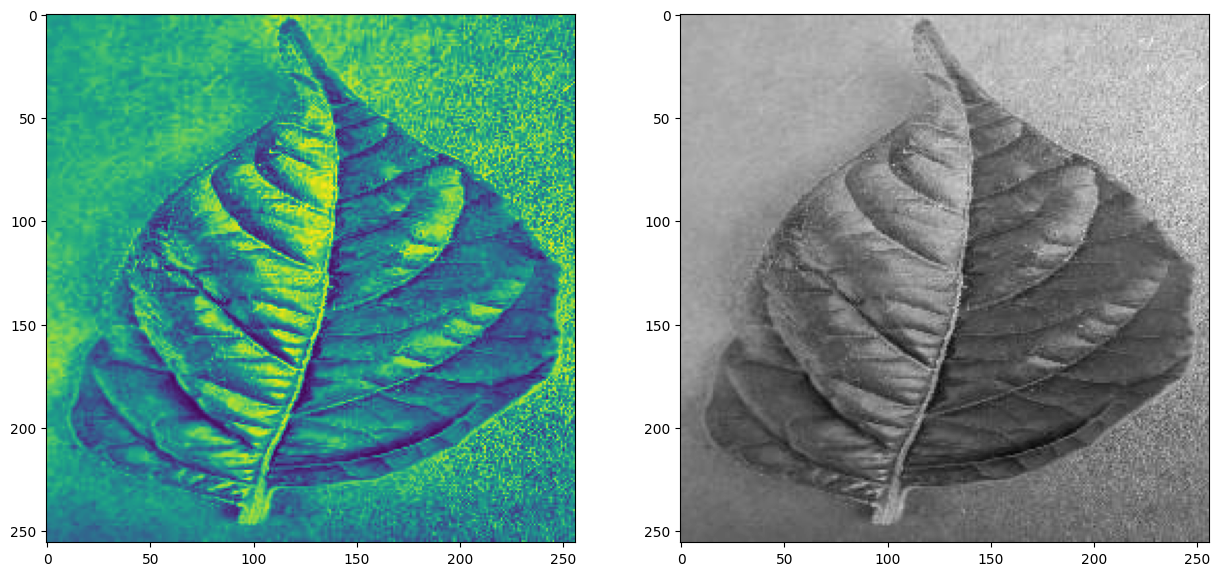

In [27]:
# image = r"C:\\Users\Admin\\align_together\\plant_detection\\124e5b7b-dc6a-4b5a-8f4e-b22ed738b5fc___JR_HL 9455_flipTB.jpg"
image = r"C:\\Users\Admin\\align_together\\plant_detection\\00726ad4-2569-46ce-9d4e-dbf82b14bd94___JR_HL 8686.jpg"
img = cv2.imread(image)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
bw = cv2.Canny(img_gray, 60, 140)
bw2 = cv2.Canny(img_gray, 60,120)
for i in bw:
    for j in range(len(i)):
        if 255 == i[j]:
            i[j] = 1
print(bw)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
# axes[0].imshow(bw, cmap='gray')
axes[1].imshow(img_gray, cmap='gray')

# Convert to LAB color space
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
# plt.imshow(lab, cmap='gray')
lab_canny = cv2.Canny(lab, 70, 120)
l_channel = lab[:,:,0]
# axes[0].imshow(lab_canny, cmap= 'gray')

# Apply Clahe:
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced = clahe.apply(l_channel)
axes[0].imshow(enhanced)

# # Create multiple Gaussian blurred images:
# blur1 = cv2.GaussianBlur(img_gray, (3,3), 0)
# blur2 = cv2.GaussianBlur(img_gray, (9,9), 0)

# # Create DoG (Difference of Gaussians)
# dog = cv2.subtract(blur1, blur2)
# dog = clahe.apply(dog[:,:,0])
# axes[0].imshow(dog)


# bw2 = cv2.Canny(lab, 60, 120)
# plt.imshow(bw2, cmap= 'gray')

# l_channel = lab[:,:,0]
# plt.imshow(bw)
# fig, axes = plt.subplots(1, 2, figsize=(15, 10))
# fig.suptitle('Leaf Analysis Results', fontsize=16)
# # axes[0].imshow(image, cmap='gray')
# # axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# axes[1].imshow(img_gray, cmap='gray')

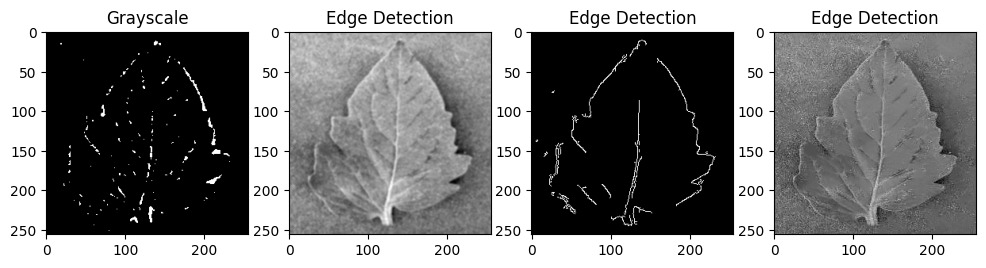

In [268]:
# Load the image
# image_path = r'C:\\Users\Admin\\align_together\\plant_detection\A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology\A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology\Arjun (P1)\\healthy\\0002_0003.JPG'
# image_path = r"C:\\Users\Admin\\align_together\\plant_detection\\pepper_healthy.jpg"
image_path = r"C:\\Users\Admin\\align_together\\plant_detection\\tomato_healthy.jpg"
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert to LAB color space
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l_channel = lab[:,:,0]

# NonlLocal Means Denoizing
denoised_nlm = cv2.fastNlMeansDenoising(gray, h=5, templateWindowSize=7, searchWindowSize=21)

# Bilateral Filter
denoised_bf = cv2.bilateralFilter(gray, d=9, sigmaColor=30, sigmaSpace=1000)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# l_channel = blurred[:,:]

# Applying CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(denoised_bf[:,:])


# Create multiple Gaussian blurred images:
blur1 = cv2.GaussianBlur(gray, (3,3), 0)
blur2 = cv2.GaussianBlur(gray, (7,7), 0)

# Create DoG (Difference of Gaussians)
dog = cv2.subtract(blur1, blur2)
dog = clahe.apply(dog[:,:])

# Dilation to strengthen the edges
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=1)

# Find contours - this can help with identifying shape and veins
contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Apply adaptive thresholding to highlight the lighter veins
adaptive_thresh = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 10
)

# High Pass Filter:
blurred_hpf = cv2.GaussianBlur(gray, (5,5), 0)
high_pass = cv2.subtract(gray, blurred_hpf)
sharpened = cv2.add(gray, high_pass)

# Edge detection using Canny
edges = cv2.Canny(denoised_bf, 30, 70)
edges2 = cv2.Canny(denoised_nlm, 50, 120)

# Draw contours for visualization
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 1)

# Display images
plt.figure(figsize=(12, 8))
# plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)), plt.title('Grayscale')
plt.subplot(1, 4, 1), plt.imshow(adaptive_thresh, cmap='gray'), plt.title('Grayscale')
plt.subplot(1, 4, 2), plt.imshow(blurred, cmap='gray'), plt.title('Edge Detection')
plt.subplot(1, 4, 3), plt.imshow(edges, cmap='gray'), plt.title('Edge Detection')
plt.subplot(1, 4, 4), plt.imshow(denoised_nlm, cmap='gray'), plt.title('Edge Detection')
# plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)), plt.title('Contours')
plt.show()

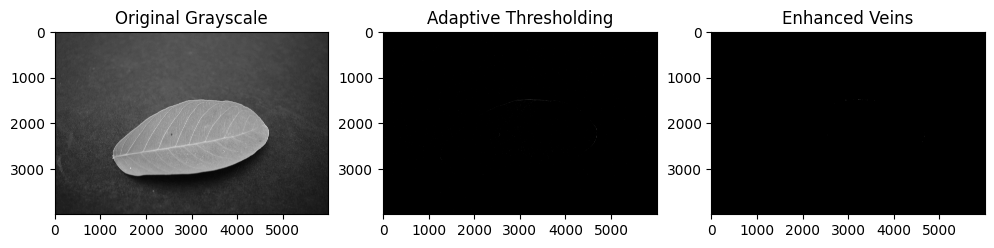

In [97]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the grayscale image (assuming the leftmost image was grayscale)
image_path = r"A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology\A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology\\Gauva (P3)\\healthy\\0004_0016.JPG"
gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply adaptive thresholding to highlight the lighter veins
adaptive_thresh = cv2.adaptiveThreshold(
    gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 10
)

# Use morphological operations to enhance vein structures
# First, we perform closing to fill small gaps
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closed = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)

# Then, apply a thinning operation (erosion followed by dilation) to highlight thin lines
thin_veins = cv2.erode(closed, kernel, iterations=1)
thin_veins = cv2.dilate(thin_veins, kernel, iterations=1)

# Display the results
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(gray_image, cmap='gray'), plt.title('Original Grayscale')
plt.subplot(1, 3, 2), plt.imshow(adaptive_thresh, cmap='gray'), plt.title('Adaptive Thresholding')
plt.subplot(1, 3, 3), plt.imshow(thin_veins, cmap='gray'), plt.title('Enhanced Veins')
plt.show()


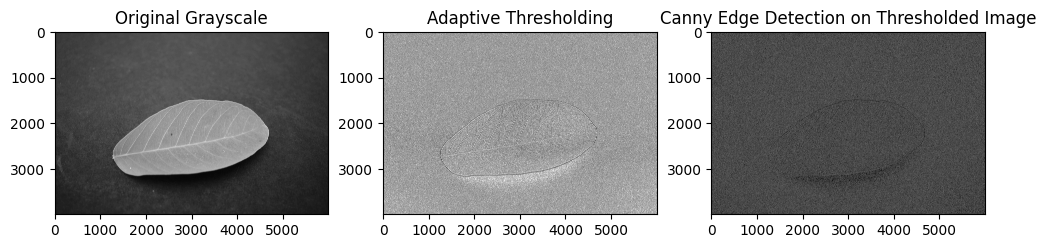

In [96]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the grayscale image
image_path = r"A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology\A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology\\Gauva (P3)\\healthy\\0004_0016.JPG"
gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply adaptive thresholding to highlight veins and edges
adaptive_thresh = cv2.adaptiveThreshold(
    gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 1
)

# Apply Canny edge detection on the thresholded image
edges = cv2.Canny(adaptive_thresh, 30, 150)

# Display the results
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1), plt.imshow(gray_image, cmap='gray'), plt.title('Original Grayscale')
plt.subplot(1, 3, 2), plt.imshow(adaptive_thresh, cmap='gray'), plt.title('Adaptive Thresholding')
plt.subplot(1, 3, 3), plt.imshow(edges, cmap='gray'), plt.title('Canny Edge Detection on Thresholded Image')
plt.show()


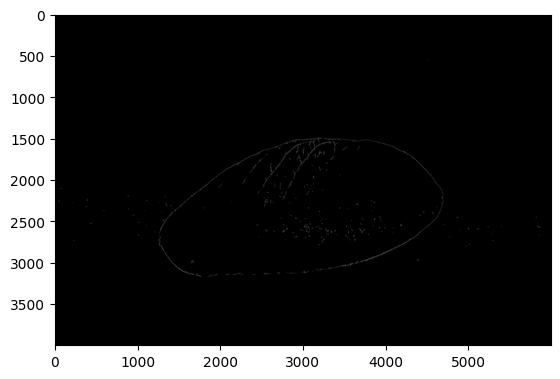

In [126]:
import cv2
import numpy as np
from PIL import Image
import requests
from io import BytesIO

def process_leaf_image(image_path):
    # Read the image
    img = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3,3), 0)
    
    # Apply Canny edge detection
    # Parameters: image, lower threshold, upper threshold
    edges = cv2.Canny(blurred, 20, 70)
    
    # Enhance the edges
    kernel = np.ones((3,3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)
    
    # Create a mask for the leaf
    ret, mask = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    
    # Combine the original image with edges
    result = img.copy()
    result[dilated_edges == 255] = [0, 255, 0]  # Highlight edges in green
    
    
    return edges, result

# Usage:
edges, enhanced = process_leaf_image(r"A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology\A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology\\Gauva (P3)\\healthy\\0004_0016.JPG")
plt.imshow(edges, cmap='gray')
